### Connecting to the postgis using sqlalchemy and manipulating the tables as geodataframes

## functions

In [1]:
def count_features(gdf, seamark):
    '''Count how many  have that specific seamark type inside
    
    Parameters
    ----------
    
    gdf : GeoDataFrame
        GeoDataFrame already filtered with a specific interest tag to be visualized
        
    seamark : str
        seamark filter tag for gdf
    '''

    counter = 0

    #iterate through each row of the df 
    for index, row in gdf.iterrows():

        #iterate through each item and key of the dictionary inside the tags column
        for key, value in row['tags'].items():
            if key == 'seamark:type' and value == seamark:
                counter += 1
            else:
                pass

    print(counter)

In [2]:
def filtered_gdf_seamark(gdf, seamark):
    '''Create new gdf with only the rows with the specified seamark
    
    Parameters
    ----------
    
    gdf : GeoDataFrame
        GeoDataFrame already filtered with a specific interest tag to be visualized
        
    seamark : str
        seamark filter tag for gdf
    '''

    return gdf[gdf['tags'].apply(lambda x: seamark in x.values())]

In [3]:
def gdf_seamark_combined(gdf, seamark_list):
    '''Create new GeoDataFrame with different seamark tags
    
    Parameters
    ----------
    
    gdf : GeoDataFrame
        GeoDataFrame of all the public.ways
        
    seamark_list : list
        list of all the tags that must be overlayed together
    '''

    gdf_list = []
    for i in range(0, len(seamark_list)):
        gdf = table_list_gdf_ways2[table_list_gdf_ways2['tags'].apply(lambda x: seamark_list[i] in x.values())]
        gdf_list.append(gdf) 


    gdf_combined = pd.concat(gdf_list)

    return gdf_combined

In [4]:
def visualize_map(gdf):
    '''Visualize features of the GeoDataFrame on a map
    
    Parameters
    ----------
    
    gdf : GeoDataFrame
        GeoDataFrame already filtered with a specific interest tag to be visualized
    '''
        
    import folium

    # Create a map centered on Germany with a zoom level of 6
    map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

    # Add OpenSeaMap tiles as a base layer
    folium.TileLayer('http://tiles.openseamap.org/seamark/{z}/{x}/{y}.png',
                     name='OpenSeaMap',
                     attr='Map data © OpenSeaMap contributors').add_to(map)

    #Add geodataframe to the map 
    folium.GeoJson(gdf,popup=folium.GeoJsonPopup(fields=list(gdf.columns[:-1]))).add_to(map)


    # Display the map
    return map

In [5]:
def visualize_map_overlay(gdf, seamark1, seamark2):
    '''Visualize features of two different GeoDataFrames with different filter seamark tags on a map 
    with different colors 
    
    Parameters
    ----------
    
    gdf : GeoDataFrame
        GeoDataFrame of all the public.ways
        
    seamark1 : str
        seamark filter tag for gdf1
        
    seamark2 : str
        seamark filter tag for gdf2
    '''
        
    import folium
    
    gdf1 = filtered_gdf_seamark(gdf, seamark1)
    gdf2 = filtered_gdf_seamark(gdf, seamark2)

    # Create a map centered on Germany with a zoom level of 6
    map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

    # Add OpenSeaMap tiles as a base layer
    folium.TileLayer('http://tiles.openseamap.org/seamark/{z}/{x}/{y}.png',
                     name='OpenSeaMap',
                     attr='Map data © OpenSeaMap contributors').add_to(map)

    #Add geodataframe to the map 
    folium.GeoJson(gdf1,popup=folium.GeoJsonPopup(fields=list(gdf1.columns[:-1])), 
                   style_function=lambda feature: {'fillColor': '#a60717', 'color': '#a60717'}).add_to(map)
    
    folium.GeoJson(gdf2,popup=folium.GeoJsonPopup(fields=list(gdf2.columns[:-1])),
                   style_function=lambda feature: {'fillColor': '#a607a3', 'color': '#a607a3'}).add_to(map)
    

    # Add the LayerControl to the map
    folium.LayerControl().add_to(map)
    

    # Display the map
    return map

In [6]:
def visualize_map_overlay_all(gdf, seamark_list):
    '''Visualize features of different GeoDataFrames with different filter seamark tags on a map
    
    Parameters
    ----------
    
    gdf : GeoDataFrame
        GeoDataFrame of all the public.ways
        
    seamark_list : list
        list with the names of all the tags to be filtered 
    '''
    
    import folium
        
    gdf_dict = {}
    for i in range(0, len(seamark_list)):
        gdf_dict[f'gdf{i}'] = filtered_gdf_seamark(gdf, seamark_list[i])
        

    # Create a map centered on Germany with a zoom level of 6
    map = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

    # Add OpenSeaMap tiles as a base layer
    folium.TileLayer('http://tiles.openseamap.org/seamark/{z}/{x}/{y}.png',
                     name='OpenSeaMap',
                     attr='Map data © OpenSeaMap contributors').add_to(map)

    
    for k, v in  gdf_dict.items():
        #Add geodataframe to the map 
        folium.GeoJson(v,popup=folium.GeoJsonPopup(fields=list(v.columns[:-1])), 
                       style_function=lambda feature: {'fillColor': '#a60717','color': '#a60717'}).add_to(map)
    

    # Display the map
    return map

In [7]:
def harbours_bbox(bbox_list):
    '''Create new gdf with all the harbours in that region of specified bbox 
    (considers harbours from ways and nodes query)

    Parameters
    ----------

    bbox_list : list
        list with the coordinates of the bbox (Xmin, Ymin, Xmax, Ymax)
    '''

    from shapely.geometry import box
    import geopandas as gpd
    
    #combine all harbour data from nodes and ways
    gdf_harbours = pd.concat([filtered_gdf_seamark(table_list_gdf_ways2, 'harbour'),filtered_gdf_seamark(table_list_gdf_nodes2, 'harbour')])

    #remove None type row 
    gdf_harbours = gdf_harbours[gdf_harbours['geom'] != None]

    #convert the geom to crs with meter units, calculate centroid from linestring features and convert again to WGS84
    gdf_harbours['geom'] = gdf_harbours.to_crs('EPSG:3035').centroid.to_crs('EPSG:4326')

    #remove duplicate records if exist
    gdf_harbours.drop_duplicates(subset=['id'], keep='first')
    
    
    if len(bbox_list):

        #specify bbox
        bbox = box(bbox_list[0], bbox_list[1], bbox_list[2], bbox_list[3])

        #select the harbours only in one specific bbox
        gdf_harbours_clip = gpd.clip(gdf_harbours, mask=bbox)
    
    else:
        #harbours without bbox
        gdf_harbours_clip = gdf_harbours
        
    return gdf_harbours_clip


In [8]:
def get_harbours_origin_destination(bbox,id_origin,id_destination):
    '''Generate a list with coordinate values for the origin / destination harbours 
    
    Parameters
    ----------

    bbox : list
        list with the coordinates of the bbox (Xmin, Ymin, Xmax, Ymax)
        
    id_origin : int
        id value for the origin harbour
        
    id_destination : int
        id value for the destination harbour
    '''
    
    harbours = harbours_bbox(bbox)

    #get coordinates (origin, destination) from interested harbours filterind by id 
    origin_harbour = harbours[harbours['id'] == id_origin]['geom']
    destination_harbour = harbours[harbours['id'] == id_destination]['geom']

    route_coordinates_longlat = [
        (origin_harbour.x.values[0], origin_harbour.y.values[0]),
        (destination_harbour.x.values[0], destination_harbour.y.values[0])
    ]

    route_coordinates_latlong = [
        (origin_harbour.y.values[0], origin_harbour.x.values[0]),
        (destination_harbour.y.values[0], destination_harbour.x.values[0])
    ]

    return route_coordinates_longlat, route_coordinates_latlong

In [9]:
def gdf_seamark_combined(seamark_object, seamark_list):
    '''Create new GeoDataFrame with different seamark tags

    Parameters
    ----------

    gdf : GeoDataFrame
        GeoDataFrame of all the public.ways (query_ways()) and public.nodes (query_nodes())

    seamark_object : str
        nodes or ways table name

    seamark_list : list
        list of all the tags that must be overlayed together
    '''
    
    tags = ['separation_zone', 'separation_line', 'separation_lane', 'restricted_area' ,'separation_roundabout']
    
    if ('nodes' in seamark_object) and (seamark_list in tags):
        gdf = table_list_gdf_nodes2
        gdf_list = []
        for i in range(0, len(seamark_list)):
            gdf = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
            gdf_list.append(gdf)
        gdf_concat = pd.concat(gdf_list)

    elif ('ways' in seamark_object) and (seamark_list in tags):
        gdf = table_list_gdf_ways2
        gdf_list = []
        for i in range(0, len(seamark_list)):
            gdf = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
            gdf_list.append(gdf)

        gdf_concat = pd.concat(gdf_list)

    elif ('nodes' in seamark_object) and ('ways' in seamark_object) and (seamark_list in tags):

        # consider the scenario for a tag present in nodes and ways at the same time
        gdf_nodes = table_list_gdf_nodes2
        gdf_ways = table_list_gdf_ways2

        #checks if there are repeated values in both gdfs
        if gdf_nodes.overlaps(gdf_ways).values.sum() == 0:
            gdf_all = pd.concat([gdf_nodes, gdf_ways])
        else:
            gdf_all =  pd.concat([gdf_nodes, gdf_ways]).drop_duplicates(subset='id', keep='first')


        gdf = gdf_all
        gdf_list = []
        for i in range(0, len(seamark_list)):
            gdf = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
            gdf_list.append(gdf)

        gdf_concat = pd.concat(gdf_list)
    else:
        print('Check the seamark object and seamark tag list')
        
    return gdf_concat


## public.nodes

In [10]:
import requests
import datetime
import os
import geopandas as gpd
import pandas as pd
def get_city_bounding_box(city_name):
    """
    Function to retrieve bounding box coordinates of a city. Input is city name as a string.
    Result can be used as input argument for function "get_box_data" which gets sensorbox data for all boxes within the given bounding box.
    """
    # Set the base URL for the API
    base_url = "https://nominatim.openstreetmap.org/search"
    # Set the search query
    query = city_name
    # Set the parameters for the API call
    params = {
        "q": query,
        "format": "json"
    }
    # Make the API call
    response = requests.get(base_url, params=params)
    #print(response.json())
    # Check the status code of the response
    if response.status_code == 200:
        # If the request was successful, the data will be in the response's JSON
        data = response.json()
        # Extract the bounding box from the response
        bounding_box = data[0]["boundingbox"]
        # Shift the order of the coordinates so that it is in the correct order as used in OpenSenseMap API calls
        bounding_box_ordered = [bounding_box[2], bounding_box[0], bounding_box[3], bounding_box[1]]
        # Join the bounding box coordinates with commas
        bounding_box_string = ",".join(bounding_box_ordered)
        # Print the result
        print(f"Bounding box of {city_name} retrieved: {bounding_box_string}")
        # Return the bounding box
        return bounding_box_string
    else:
        # If the request was not successful, print and return the error message
        #print(response.text)
        return response.text

In [11]:
get_city_bounding_box('Germany')

Bounding box of Germany retrieved: 5.8663153,47.2701114,15.0419309,55.0991610


'5.8663153,47.2701114,15.0419309,55.0991610'

In [12]:
import os
import sqlalchemy as db
import pandas as pd
import geopandas as gpd
from dotenv import load_dotenv

# Load the environment variables from the .env file
load_dotenv("./python_docker/.env")


# Connect to the PostgreSQL database using SQLAlchemy
engine = db.create_engine('postgresql://{user}:{pw}@{host}/{db}'
                           .format(user=os.environ.get("POSTGIS_USER"),
                                   pw=os.environ.get("POSTGIS_PASSWORD"),
                                   host="172.20.0.3",
                                   db=os.environ.get("POSTGIS_DATABASE"),
                                   port='5434'))


connection = engine.connect()

# Define SQL query to retrieve list of tables
#sql_query = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'"

query = "SELECT * FROM nodes"
#query = f"SELECT * FROM nodes WHERE ST_Intersects(geom, ST_MakeEnvelope({-14.282227}, {42.358544}, {12.963867}, {59.130863}, 4326))"
#query = f"SELECT * FROM nodes WHERE ST_Intersects(geom, ST_MakeEnvelope({get_city_bounding_box('Germany')}, 4326))"

# Use pandas to read the SQL query into a dataframe
#table_list_df = pd.read_sql(sql_query, engine)

# Use geopandas to read the SQL query into a dataframe from postgis
table_list_gdf_nodes = gpd.read_postgis(query, engine,geom_col='geom')

# read timestamp type data as string
table_list_gdf_nodes['tstamp']=table_list_gdf_nodes['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

table_list_gdf_nodes

,id,version,user_id,tstamp,changeset_id,tags,geom
0,106904,5,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03623 51.51956)
1,108735,6,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03489 51.51475)
2,110210,7,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03777 51.52499)
3,142325,5,53773,2017-04-26 14:43:20,48165623,{},POINT (6.16037 49.11819)
4,148969,14,420980,2018-10-23 11:53:56,63792931,{},POINT (11.23781 60.42730)
...,...,...,...,...,...,...,...
2124700,11040475916,1,124870,2023-07-11 21:52:06,138396972,{},POINT (20.21348 59.92810)
2124701,11040475917,1,124870,2023-07-11 21:52:06,138396972,{},POINT (20.21348 59.92808)
2124702,11040475918,1,124870,2023-07-11 21:52:06,138396972,{},POINT (20.21352 59.92806)
2124703,11040475919,1,124870,2023-07-11 21:52:06,138396972,{},POINT (20.21354 59.92804)


In [13]:
import os
import sqlalchemy as db
import pandas as pd
import geopandas as gpd
from dotenv import load_dotenv

# Load the environment variables from the .env file
load_dotenv("./python_docker/.env")


# Connect to the PostgreSQL database using SQLAlchemy
engine = db.create_engine('postgresql://{user}:{pw}@{host}/{db}'
                           .format(user=os.environ.get("POSTGIS_USER"),
                                   pw=os.environ.get("POSTGIS_PASSWORD"),
                                   host="172.20.0.3",
                                   db=os.environ.get("POSTGIS_DATABASE"),
                                   port='5434'))


connection = engine.connect()

# Define SQL query to retrieve list of tables
#sql_query = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'"

# query = "SELECT * FROM nodes LIMIT 500"
#query = f"SELECT * FROM nodes WHERE ST_Intersects(geom, ST_MakeEnvelope({-14.282227}, {42.358544}, {12.963867}, {59.130863}, 4326))"
#query = f"SELECT * FROM land_polygons WHERE ST_Intersects(geometry, ST_MakeEnvelope({get_city_bounding_box('Germany')}, 4326))"
query = f"SELECT * FROM land_polygons"
# Use pandas to read the SQL query into a dataframe
#table_list_df = pd.read_sql(sql_query, engine)

# Use geopandas to read the SQL query into a dataframe from postgis
table_list_gdf_land = gpd.read_postgis(query, engine,geom_col='geometry')
table_list_gdf_land.set_crs="EPSG:4326"
# read timestamp type data as string
#table_list_gdf_nodes['tstamp']=table_list_gdf_nodes['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

table_list_gdf_land

,FID,geometry
0,0,"POLYGON ((-4.94237 55.72545, -4.94192 55.72559..."
1,1,"POLYGON ((-4.94051 55.72458, -4.94049 55.72407..."
2,2,"POLYGON ((-4.73290 55.52496, -4.73380 55.52495..."
3,3,"POLYGON ((-4.95385 55.16290, -4.95388 55.16341..."
4,4,"POLYGON ((-1.75372 50.72274, -1.75350 50.72284..."
...,...,...
740750,740750,"POLYGON ((21.01898 60.54063, 21.01896 60.54063..."
740751,740751,"POLYGON ((20.25760 59.94406, 20.25756 59.94405..."
740752,740752,"POLYGON ((20.22910 59.93757, 20.22908 59.93758..."
740753,740753,"POLYGON ((20.22908 59.93762, 20.22907 59.93762..."


In [14]:
table_list_gdf_land[:100].explore()

In [59]:
ger=gpd.read_file('/home/igor/projects/maridata/test_data/DEU_adm0.shp')

In [1]:
import geopandas as gpd


In [3]:
gdf_land = gpd.read_file('/home/igor/projects/maridata/test_data/land-polygons-complete-4326/land_polygons.shp')

<Axes: >

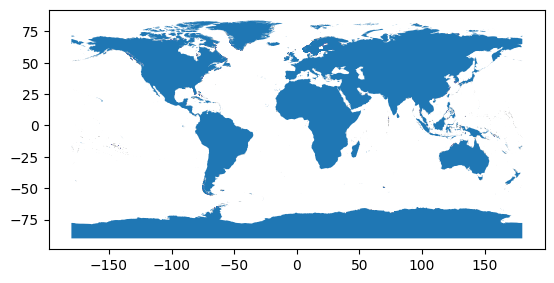

In [4]:
gdf_land.plot()

In [12]:
# Create a copy of the df to test the functions
table_list_gdf_nodes2 = table_list_gdf_nodes.copy()

In [13]:
table_list_gdf_nodes2.head()

,id,version,user_id,tstamp,changeset_id,tags,geom
0,106904,5,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03623 51.51956)
1,108735,6,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03489 51.51475)
2,110210,7,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03777 51.52499)
3,142325,5,53773,2017-04-26 14:43:20,48165623,{},POINT (6.16037 49.11819)
4,148969,14,420980,2018-10-23 11:53:56,63792931,{},POINT (11.23781 60.42730)


## public.ways

In [15]:
import os
import sqlalchemy as db
import pandas as pd
import geopandas as gpd
from dotenv import load_dotenv

# Load the environment variables from the .env file
load_dotenv("./python_docker/.env")


# Connect to the PostgreSQL database using SQLAlchemy
engine = db.create_engine('postgresql://{user}:{pw}@{host}/{db}'
                           .format(user=os.environ.get("POSTGIS_USER"),
                                   pw=os.environ.get("POSTGIS_PASSWORD"),
                                   host="172.20.0.3",
                                   db=os.environ.get("POSTGIS_DATABASE"),
                                   port='5434'))


connection = engine.connect()


# query = "SELECT * FROM nodes LIMIT 500"
query = "SELECT *, linestring AS geom FROM ways"  #linestring is the column representing the geometry 


# Use geopandas to read the SQL query into a dataframe from postgis
table_list_gdf_ways = gpd.read_postgis(query, engine)

# read timestamp type data as string
table_list_gdf_ways['tstamp']=table_list_gdf_ways['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

table_list_gdf_ways.head(100)

,id,version,user_id,tstamp,changeset_id,tags,nodes,linestring,geom
0,2957004,5,402585,2017-07-22 12:54:36,50480937,"{'source': 'PGS', 'natural': 'coastline', 'sea...","[13894718, 13894717, 4986641664, 13894716, 138...",0102000020E6100000060000007FA9FAF087BAFFBFDA6D...,"LINESTRING (-1.98304 49.29275, -1.98302 49.292..."
1,2957006,3,402585,2017-07-22 12:54:37,50480937,"{'place': 'islet', 'source': 'PGS', 'natural':...","[13894731, 13894734, 4986641279, 4986641278, 1...",0102000020E61000000A000000734A404CC2E5FEBFC6AA...,"LINESTRING (-1.93109 49.29145, -1.93099 49.291..."
2,2957007,3,402585,2017-07-22 12:54:37,50480937,"{'source': 'PGS', 'natural': 'coastline', 'sea...","[13894739, 13894738, 13894737, 4986641686, 138...",0102000020E610000009000000756A78C43227FFBF32FA...,"LINESTRING (-1.94707 49.29174, -1.94753 49.291..."
3,3303804,18,12324550,2020-12-12 17:23:50,95730345,"{'name': 'Royal Portbury Dock', 'landuse': 'ha...","[967266897, 1359492542, 1359492545, 16269599, ...",0102000020E61000009E000000DC3D8A8400CA05C05CE0...,"LINESTRING (-2.72363 51.49807, -2.72379 51.497..."
4,3353382,30,4081914,2023-05-27 15:32:33,136629148,"{'boat': 'private', 'name': 'Chichester Marina...","[10931738411, 2145855710, 7992523685, 32005940...",0102000020E610000066000000E749E361EB63EABF2725...,"LINESTRING (-0.82470 50.80485, -0.82467 50.804..."
...,...,...,...,...,...,...,...,...,...
95,4122773,14,1196017,2023-02-12 06:39:04,132432072,{'natural': 'coastline'},"[1133815892, 8559041160, 8559041159, 113381506...",0102000020E610000080010000C6CCF40137292640FE85...,"LINESTRING (11.08050 55.51504, 11.08059 55.515..."
96,4123131,4,22869,2017-12-19 19:10:28,54768203,"{'name': 'Langø', 'place': 'islet', 'natural':...","[1332777878, 5294319141, 5294319140, 22662722,...",0102000020E6100000360000009EE4B3E1559B27400489...,"LINESTRING (11.80339 55.74656, 11.80343 55.746..."
97,42818785,3,2781619,2020-08-20 19:59:07,89709807,"{'foot': 'permissive', 'waterway': 'lock_gate'...","[535540441, 535540446, 7805125485]",0102000020E6100000030000007B33C5773D0053C01F38...,"LINESTRING (-76.00375 44.89303, -76.00381 44.8..."
98,4122839,12,379467,2021-04-14 07:11:28,102908549,{'natural': 'coastline'},"[25070189, 22651799, 22651796, 6109593023, 610...",0102000020E6100000B2010000CB3049C043002840C80B...,"LINESTRING (12.00052 55.85989, 12.00033 55.859..."


In [16]:
# Create a copy of the df to test the functions
table_list_gdf_ways2 = table_list_gdf_ways.copy()

#### Tests 

In [15]:
if ("nodes" in seamark_object) and all(element in tags for element in seamark_list):
    gdf = table_list_gdf_nodes2#self.query_nodes(engine,query)
    gdf_list = []
    for i in range(0, len(seamark_list)):
        gdf1 = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
        gdf_list.append(gdf1)
    gdf_concat = pd.concat(gdf_list)
    
    

NameError: name 'seamark_object' is not defined

In [ ]:
gdf_concat['tags']

In [17]:
test_nodes_gdf = gpd.GeoDataFrame(columns=['tags', 'geometry'],
             data=[[{'waterway': 'lock_gate', 'seamark:type': 'gate'},Point(5, 15)],
                   [{'seamark:type': 'harbour'},Point(9.91950, 57.06081)],
                   [{'seamark:type': 'buoy_cardinal'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_boundary'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_crossing'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_lane'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_roundabout'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_zone'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'restricted_area'},Point(12.01631, 48.92595)],
                  ])


NameError: name 'Point' is not defined

In [ ]:
test_nodes_gdf = gpd.GeoDataFrame(columns=['tags', 'geometry'],
             data=[[{'waterway': 'lock_gate', 'seamark:type': 'gate'},Point(5, 15)],
                   [{'seamark:type': 'harbour'},Point(9.91950, 57.06081)],
                   [{'seamark:type': 'buoy_cardinal'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_boundary'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_crossing'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_lane'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_roundabout'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_zone'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'restricted_area'},Point(12.01631, 48.92595)],
                  ])


In [ ]:
ways_gdf = gpd.GeoDataFrame(columns=['tags', 'geometry'],
             data=[
                   [{'seamark:type': 'separation_boundary'},LineString([(3.2738333, 51.8765), (3.154833, 51.853667)])],
                   [{'seamark:type': 'separation_crossing'},LineString([(6.3732417, 54.192091), (6.3593333, 54.1919199),(6.3310833, 54.1905871), (6.3182992, 54.189601)])],
                   [{'seamark:type': 'separation_lane'},LineString([(24.6575999, 59.6085725), (24.7026512, 59.5505585)])],
                   [{'seamark:type': 'separation_roundabout'},LineString([(27.9974563, 43.186327), (27.998524, 43.1864565),(27.9995173, 43.186412), (28.0012373, 43.1859232), (28.0020059, 43.1854689), (28.0025203, 43.1850186),(28.0029253, 43.1845006), (28.0032216, 43.1838693),(27.9947856, 43.1813859), (27.9944414, 43.1819034),(27.9941705, 43.1826993), (27.9941723, 43.1835194),(27.9944142, 43.1842511), (27.9947709, 43.1848037),(27.9953623, 43.1853841), (27.9961109, 43.1858589),(27.9974563, 43.186327)])],
                   [{'seamark:type': 'separation_zone'},LineString([(-1.9830398, 49.2927514), (-1.9830233, 49.2925889), (-1.9828257, 49.2924815), (-1.9827145, 49.2925089),(-1.9828543, 49.2927771), (-1.9830398, 49.2927514)])],
                   [{'seamark:type': 'restricted_area'},LineString([(12.3569916, 47.9186626), (12.3567217, 47.9188108),(12.3564934, 47.9189565), (12.3564734, 47.9191199),(12.3565413, 47.9192803), (12.3568636, 47.919524),(12.3571719, 47.9196858), (12.3575482, 47.9197593),(12.3579399, 47.9198024), (12.3587152, 47.9200541),(12.3594448, 47.9203064), (12.3596907, 47.9203917),(12.3599993, 47.9204654), (12.3604107, 47.9205391),(12.3608174, 47.9205554), (12.3610279, 47.9205224),(12.3612053, 47.9204511), (12.3614394, 47.9201326),(12.3616484, 47.9198195), (12.3616249, 47.9196335),(12.361631, 47.9194503), (12.3616174, 47.9193071),(12.36156, 47.9192435), (12.3614394, 47.9191936),(12.3611173, 47.9191633), (12.3609535, 47.9190676),(12.3607335, 47.9189749), (12.3604259, 47.918891),(12.3595763, 47.9187613), (12.3587674, 47.9185358),(12.3584371, 47.9183784), (12.3582044, 47.9182997),(12.3579056, 47.918306), (12.3576587, 47.9183381),(12.3573105, 47.9184692), (12.3569916, 47.9186626)])],
                  ])

ways_gdf

In [112]:
type(dict(test_nodes_gdf['tags'].iloc[0]))

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [ ]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///gdfDB.db")

In [ ]:
test_nodes_gdf.to_file("gdfDB.db",driver='SQLite', spatialite=True, layer='nodes')

In [ ]:
ways_gdf.to_file("gdfDB.db",driver='SQLite', spatialite=True, layer='ways')

In [ ]:
node1 =gpd.read_postgis('select *,geometry as geom from nodes',con=engine,geom_col="geom").drop(['GEOMETRY'],axis=1)


In [ ]:
ways1 = gpd.read_postgis('select *,geometry as geom from ways',con=engine,geom_col="geom").drop(['GEOMETRY'],axis=1)


In [ ]:
pd.concat([node1,ways1])

In [133]:
sd['tags'].apply(lambda x: dict(x))

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [105]:
type(sd['tags'].iloc[0])

str

In [135]:
seamark_object=['nodes']
tags = ['separation_zone', 'separation_line', 'separation_lane', 'restricted_area' ,'separation_roundabout']
seamark_list =['separation_zone','separation_line']

In [ ]:
def check_type(gdf):
    if 

In [143]:
import ast

if ("nodes" in seamark_object) and all(element in tags for element in seamark_list):
    gdf_test = table_list_gdf_nodes2#gpd.read_postgis('select *,geometry as geom from nodes',con=engine,geom_col="geom").drop(['GEOMETRY'],axis=1)#test_nodes_gdf#self.query_nodes(engine,query)
    #gdf_test['tags']=gdf_test['tags'].apply(ast.literal_eval)
    gdf_list = []
    
    
    for i in range(0, len(seamark_list)):
        if type(gdf_test['tags'][i]) == str:
            gdf_test['tags']=gdf_test['tags'].apply(ast.literal_eval)
            gdf1 = gdf_test[gdf_test['tags'].apply(lambda x: seamark_list[i] in x.values())]
            gdf_list.append(gdf1)
        else:
            gdf1 = gdf_test[gdf_test['tags'].apply(lambda x: seamark_list[i] in x.values())]
            gdf_list.append(gdf1)
    gdf_concat = pd.concat(gdf_list)



gdf_concat

,id,version,user_id,tstamp,changeset_id,tags,geom,geometry
1482964,7233992189,1,78466,2020-02-21 20:00:11,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",0101000020E61000003804D89134C52740A4703D0AD79B...,POINT (11.88517 57.21750)
1482967,7233992287,1,78466,2020-02-21 20:00:10,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",0101000020E61000008D976E1283C02740B271B32E249D...,POINT (11.87600 57.22767)
1482968,7233992288,1,78466,2020-02-21 20:00:12,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",0101000020E61000009D741195FCC227406A90381A769D...,POINT (11.88083 57.23017)
1482969,7233992289,1,78466,2020-02-21 20:00:13,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",0101000020E610000036D9507B5BB62740CB75093D519F...,POINT (11.85617 57.24467)
1482970,7233992585,1,78466,2020-02-21 20:00:09,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",0101000020E6100000D4FD52F5E1B3274012578451FF9E...,POINT (11.85133 57.24217)
1482971,7233992586,1,78466,2020-02-21 20:00:12,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",0101000020E61000009CC420B072C82740B49C3A45FD9B...,POINT (11.89150 57.21867)


In [64]:
gdf_concat

,tags,geometry
7,{'seamark:type': 'separation_zone'},POINT (12.01631 48.92595)


In [56]:
gdf_list

[                                  tags                   geometry
 7  {'seamark:type': 'separation_zone'}  POINT (12.01631 48.92595),
 Empty GeoDataFrame
 Columns: [tags, geometry]
 Index: []]

In [48]:
type(test_nodes_gdf['tags'][0])

dict

In [144]:
pd.concat([table_list_gdf_nodes2, table_list_gdf_ways2])

,id,version,user_id,tstamp,changeset_id,tags,geom,geometry,nodes,linestring
0,106904,5,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",0101000020E61000000E1714611E8DA2BF53FBBEC980C2...,POINT (-0.03623 51.51956),NaN,NaN
1,108735,6,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",0101000020E61000007FA6B9707BDDA1BF3EDC1F39E3C1...,POINT (-0.03489 51.51475),NaN,NaN
2,110210,7,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",0101000020E6100000B12C3D3F3157A3BFAA4F28FA32C3...,POINT (-0.03777 51.52499),NaN,NaN
3,142325,5,53773,2017-04-26 14:43:20,48165623,{},0101000020E6100000969E44DF38A41840E3D3ADE8208F...,POINT (6.16037 49.11819),NaN,NaN
4,148969,14,420980,2018-10-23 11:53:56,63792931,{},0101000020E61000002651D43EC279264004CCD7C0B136...,POINT (11.23781 60.42730),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
102503,1173235725,1,449569,2023-05-16 08:38:33,136157239,"{'seamark:type': 'small_craft_facility', 'seam...","LINESTRING (-92.4506241 42.5399962, -92.450676...",None,"[10901378809, 10901378833]",0102000020E61000000200000086127706D71C57C06D7B...
102504,1173235727,1,449569,2023-05-16 08:38:33,136157239,"{'highway': 'service', 'seamark:type': 'small_...","LINESTRING (-92.4506056 42.5400255, -92.450624...",None,"[10901378834, 10901378809]",0102000020E6100000020000003FD9DEB8D61C57C0C6C0...
102505,1173238209,1,449569,2023-05-16 08:51:33,136157823,"{'seamark:type': 'small_craft_facility', 'seam...","LINESTRING (-92.4337828 42.5298889, -92.433710...",None,"[10901366558, 10901366559]",0102000020E6100000020000004FE4EE18C31B57C0B801...
102506,1173400995,2,17531229,2023-05-16 17:31:40,136179862,"{'name': 'Бейбарс Газ', 'building': 'yes', 'wa...","LINESTRING (69.4201454 42.4884203, 69.4202495 ...",None,"[10902512013, 10902512014, 10902512015, 109025...",0102000020E610000005000000262488A9E35A5140EC99...


In [15]:
def gdf_seamark_combined(seamark_object, seamark_list):
    '''Create new GeoDataFrame with different seamark tags

    Parameters
    ----------

    gdf : GeoDataFrame
        GeoDataFrame of all the public.ways (query_ways()) and public.nodes (query_nodes())

    seamark_object : str
        nodes or ways table name

    seamark_list : list
        list of all the tags that must be overlayed together
    '''
    
    
    tags = ['separation_zone', 'separation_line', 'separation_lane', 'restricted_area' ,'separation_roundabout']
    
    gdf_concat = gpd.GeoDataFrame()
    
    if ('nodes' in seamark_object) and (seamark_list in tags):
        gdf = table_list_gdf_nodes2
        gdf_list = []
        for i in range(0, len(seamark_list)):
            gdf = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
            gdf_list.append(gdf)
        gdf_concat = pd.concat(gdf_list)
        
    return gdf_concat


In [16]:
gdf_seamark_combined(seamark_object='nodes', seamark_list=['separation_line','separation_zone'])

""


In [28]:
from shapely.geometry import Point 
#Creating dummy data
point1 = {"tags": [{'seamark:type':'separation_line'}], "geometry": [Point(1, 2)]}
point1_df = gpd.GeoDataFrame(point1)
point2 = {"tags": [{'seamark:type':'separation_lane'}], "geometry": [Point(6, 2)]}
point2_df = gpd.GeoDataFrame(point2)

concat_df= pd.concat([point1_df, point2_df])

concat_df

,tags,geometry
0,{'seamark:type': 'separation_line'},POINT (1.00000 2.00000)
0,{'seamark:type': 'separation_lane'},POINT (6.00000 2.00000)


In [35]:
nodes_concat = gdf_seamark_combined(seamark_object=['nodes'], seamark_list=['separation_line','separation_zone'])

In [36]:
nodes_concat

""


In [31]:
assert type(concat_df) == type(nodes_concat), 'Concat dataframe type error'

assert concat_df['tags'].values in nodes_concat['tags'].values, 'Not working'
for geom in nodes_concat["geometry"]:
    assert isinstance(geom, Point), "Point Instantiation Error"

KeyError: 'tags'

In [45]:
tags = ['separation_zone', 'separation_line', 'separation_lane', 'restricted_area' ,'separation_roundabout']

gdf_concat = gpd.GeoDataFrame()

seamark_object = ['nodes']

seamark_list = ['separation_line', 'separation_zone']

if ('nodes' in seamark_object) and (seamark_list in tags):
    gdf = table_list_gdf_nodes2
    print('hi')



SyntaxError: invalid syntax (3614487336.py, line 9)

In [46]:
print(set(seamark_list))

{'separation_zone', 'separation_line'}


In [51]:
['separation_line', 'separation_zone'] in ['separation_zone', 'separation_line', 'separation_lane', 'restricted_area' ,'separation_roundabout', ['separation_line', 'separation_zone']]

True

In [49]:
seamark_list

['separation_line', 'separation_zone']

In [53]:
seamark_list

['separation_line', 'separation_zone']

In [56]:
[element for element in seamark_list if in tags]

SyntaxError: invalid syntax (2268354908.py, line 1)

In [58]:
if all(element in tags for element in seamark_list):
    print('true')

true


In [63]:
if ("nodes" in seamark_object) and all(element in tags for element in seamark_list):
    print('ok')
    gdf_list = []
    gdf = table_list_gdf_nodes2
    for i in range(0, len(seamark_list)):
        gdf = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
        gdf_list.append(gdf)

    if gdf_list:  # Check if gdf_list is not empty
        gdf_concat = pd.concat(gdf_list)


ok


In [64]:
gdf_concat

,id,version,user_id,tstamp,changeset_id,tags,geom


In [68]:
gdf = table_list_gdf_nodes2

In [66]:
table_list_gdf_nodes2

,id,version,user_id,tstamp,changeset_id,tags,geom
0,106904,5,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03623 51.51956)
1,108735,6,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03489 51.51475)
2,110210,7,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03777 51.52499)
3,142325,5,53773,2017-04-26 14:43:20,48165623,{},POINT (6.16037 49.11819)
4,148969,14,420980,2018-10-23 11:53:56,63792931,{},POINT (11.23781 60.42730)
...,...,...,...,...,...,...,...
2098804,10902976542,1,19205214,2023-05-16 18:40:38,136182192,"{'name': 'Bharat Petroleum', 'waterway': 'fuel...",POINT (84.99226 24.79133)
2098805,10903429078,1,1713634,2023-05-16 21:15:57,136186650,{},POINT (9.91946 57.06074)
2098806,10903429079,1,1713634,2023-05-16 21:15:57,136186650,{},POINT (9.91950 57.06081)
2098807,10903509066,1,137242,2023-05-16 21:01:48,136186282,{},POINT (12.01625 48.92597)


In [86]:
list_example = list(gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]['tags'].map(lambda x: list(x.values())))

In [94]:
if all(element in list_example for element in ['separation_zone']):
    True
    print('worked')
else:
    print('not working')

not working


In [96]:
set(seamark_list).intersection(set(tags))

{'separation_line', 'separation_zone'}

In [97]:
seamark_list

['separation_line', 'separation_zone']

In [98]:
tags

['separation_zone',
 'separation_line',
 'separation_lane',
 'restricted_area',
 'separation_roundabout']

In [108]:
tags = ['separation_zone', 'separation_line', 'separation_lane', 'restricted_area' ,'separation_roundabout']

gdf_concat = gpd.GeoDataFrame()

seamark_object = ['nodes']

seamark_list = ['separation_line', 'separation_zone']

tags_filtered = list(set(seamark_list).intersection(set(tags)))

if ("nodes" in seamark_object) and ([element for element in seamark_list] in tags_filtered) or len(query)==1:
    gdf_list = []
    gdf = table_list_gdf_nodes2
    for i in range(0, len(seamark_list)):
        gdf = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
        gdf_list.append(gdf)

In [105]:
gdf_list

[Empty GeoDataFrame
 Columns: [id, version, user_id, tstamp, changeset_id, tags, geom]
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

In [106]:
tags_filtered

['separation_zone', 'separation_line']

In [107]:
list(set(seamark_list).intersection(set(tags))) == list(set(seamark_list).intersection(set(tags)))

True

In [112]:
([element for element in seamark_list] in tags)

False

In [113]:
seamark_list

['separation_line', 'separation_zone']

In [114]:
[element for element in seamark_list]

['separation_line', 'separation_zone']

In [115]:
seamark_list

['separation_line', 'separation_zone']

In [116]:
x = [1,4,6]

In [125]:
[i for i in seamark_list] in ['separation_line', 'separation_zone']

False

In [122]:
for element in seamark_list:
    seamark_list

['separation_line', 'separation_zone']

In [134]:
tags = ['separation_zone', 'separation_line', 'separation_lane', 'restricted_area' ,'separation_roundabout']

gdf_concat = gpd.GeoDataFrame()

seamark_object = ['nodes']

seamark_list = ['separation_line', 'separation_zone']

if ("nodes" in seamark_object) and all(element in tags for element in seamark_list) or len(query)==1:
    gdf = table_list_gdf_nodes2
    gdf_list = []
    print(gdf)
    print(gdf_list)
    for i in range(0, len(seamark_list)):
        gdf = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
        gdf_list.append(gdf)
    gdf_concat = pd.concat(gdf_list)

                  id  version   user_id               tstamp  changeset_id   
0             106904        5   4948143  2020-06-15 19:23:35      86684855  \
1             108735        6   4948143  2020-06-15 19:23:35      86684855   
2             110210        7   4948143  2020-06-15 19:23:35      86684855   
3             142325        5     53773  2017-04-26 14:43:20      48165623   
4             148969       14    420980  2018-10-23 11:53:56      63792931   
...              ...      ...       ...                  ...           ...   
2098804  10902976542        1  19205214  2023-05-16 18:40:38     136182192   
2098805  10903429078        1   1713634  2023-05-16 21:15:57     136186650   
2098806  10903429079        1   1713634  2023-05-16 21:15:57     136186650   
2098807  10903509066        1    137242  2023-05-16 21:01:48     136186282   
2098808  10903509067        1    137242  2023-05-16 21:01:48     136186282   

                                                      tags   
0

In [138]:
gdf.columns

Index([], dtype='object')

In [140]:
gdf = table_list_gdf_nodes2
gdf.columns

Index(['id', 'version', 'user_id', 'tstamp', 'changeset_id', 'tags', 'geom'], dtype='object')

In [142]:
gdf['tags']

0          {'waterway': 'lock_gate', 'seamark:type': 'gate'}
1          {'waterway': 'lock_gate', 'seamark:type': 'gate'}
2          {'waterway': 'lock_gate', 'seamark:type': 'gate'}
3                                                         {}
4                                                         {}
                                 ...                        
2098804    {'name': 'Bharat Petroleum', 'waterway': 'fuel...
2098805                                                   {}
2098806                                                   {}
2098807                                                   {}
2098808                                                   {}
Name: tags, Length: 2098809, dtype: object

In [128]:
gdf_list

[Empty GeoDataFrame
 Columns: [id, version, user_id, tstamp, changeset_id, tags, geom]
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

In [129]:
all(element in tags for element in seamark_list)

True

In [130]:
for i in range(0, len(seamark_list)):
        gdf = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]

KeyError: 'tags'

In [132]:
gdf

""


In [143]:
tags = ['separation_zone', 'separation_line', 'separation_lane', 'restricted_area' ,'separation_roundabout']

gdf_concat = gpd.GeoDataFrame()

seamark_object = ['nodes']

seamark_list = ['separation_line', 'separation_zone']

In [147]:
##################### optional for the moment ######################
if ("nodes" in seamark_object) and all(element in tags for element in seamark_list) or len(query)==1:
    gdf = table_list_gdf_nodes2
    gdf_list = []
    for i in range(0, len(seamark_list)):
        gdf = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
        gdf_list.append(gdf)
    gdf_concat = pd.concat(gdf_list)

In [149]:
gdf_list

[Empty GeoDataFrame
 Columns: [id, version, user_id, tstamp, changeset_id, tags, geom]
 Index: [],
 Empty DataFrame
 Columns: []
 Index: []]

In [158]:
gdf1 = table_list_gdf_nodes2[table_list_gdf_nodes2['tags'].map(lambda x: 'separation_zone' in x.values())]

In [157]:
gdf2 = table_list_gdf_nodes2[table_list_gdf_nodes2['tags'].map(lambda x: 'separation_line' in x.values())]

In [160]:
gdf2

,id,version,user_id,tstamp,changeset_id,tags,geom


In [162]:
gdf_list = []

In [163]:
gdf_list.append(gdf1)

In [165]:
gdf_list.append(gdf2)

In [167]:
len(gdf_list)

2

In [169]:
gdf_list[1]

,id,version,user_id,tstamp,changeset_id,tags,geom


In [173]:
gdf_result = pd.concat(gdf_list)

In [174]:
gdf_result

,id,version,user_id,tstamp,changeset_id,tags,geom
1482964,7233992189,1,78466,2020-02-21 20:00:11,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",POINT (11.88517 57.21750)
1482967,7233992287,1,78466,2020-02-21 20:00:10,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",POINT (11.87600 57.22767)
1482968,7233992288,1,78466,2020-02-21 20:00:12,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",POINT (11.88083 57.23017)
1482969,7233992289,1,78466,2020-02-21 20:00:13,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",POINT (11.85617 57.24467)
1482970,7233992585,1,78466,2020-02-21 20:00:09,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",POINT (11.85133 57.24217)
1482971,7233992586,1,78466,2020-02-21 20:00:12,81331358,"{'name': 'TSS Fladen', 'seamark:type': 'separa...",POINT (11.89150 57.21867)


In [185]:
#creating dummy data point
nodes1 = {"tags": [{'seamark:type': 'separation_line'},
                   {'seamark:type': 'separation_zone'},
                   {''}],
            "geometry": [Point(1, 2), Point(4, 7), None]}
nodes_df = gpd.GeoDataFrame(nodes1)

ways1 = {"tags": [{'seamark:type': 'separation_line'},
                    {'seamark:type': 'separation_zone'},
                    {'seamark:type': 'restricted_area'},
                    {''}],
           "geometry": [LineString([(7, 8), (5, 9)]), LineString([(16, 14), (8, 13)]), LineString([(2, 11), (7, 15)]), None]}

ways_df = gpd.GeoDataFrame(ways1)

concat_df = pd.concat([nodes_df, ways_df])
concat_df

,tags,geometry
0,{'seamark:type': 'separation_line'},POINT (1.00000 2.00000)
1,{'seamark:type': 'separation_zone'},POINT (4.00000 7.00000)
2,{},None
0,{'seamark:type': 'separation_line'},"LINESTRING (7.00000 8.00000, 5.00000 9.00000)"
1,{'seamark:type': 'separation_zone'},"LINESTRING (16.00000 14.00000, 8.00000 13.00000)"
2,{'seamark:type': 'restricted_area'},"LINESTRING (2.00000 11.00000, 7.00000 15.00000)"
3,{},None


In [186]:
route = {"tags": [{'seamark:type': 'separation_line'}], "geometry": [LineString([(7, 8), (5, 9)])]}
route_df = gpd.GeoDataFrame(route)
route_df

,tags,geometry
0,{'seamark:type': 'separation_line'},"LINESTRING (7.00000 8.00000, 5.00000 9.00000)"


In [166]:
def check_crosses():
    query_tree = []
    tree_list = []
    for predicate in predicates:
        tree = STRtree(concat_df['geometry'])
        tree_list.append(tree)
        #route['geometry'] should e the geometry of the route that will be tested
        geom_object= (tree.query(route_df['geometry'], predicate=predicate).tolist())
        #print(f'{a} on the predicate {predicate}')
        #query_tree.append(geom_object)
        if geom_object == [[],[]] or geom_object == []:
            print(f'no {predicate} for the geometry objects with {geom_object}')
        else:
            print(f'{predicate} for the geometry object with {geom_object}')
            query_tree.append((tree,predicate,geom_object))
        #no_null_tree = [sublist for sublist in query_tree if sublist != [[], []]]
        #print(new_tree)
    return query_tree
    # if tree != '[[], []]':
    #     query_tree.append(tree)
    # else:
#     #     logger.info('No crossing')
# for tree in query_tree:
check_crosses()

intersects for the geometry object with [[0], [3]]
contains for the geometry object with [[0], [3]]
no touches for the geometry objects with [[], []]
no crosses for the geometry objects with [[], []]
no overlaps for the geometry objects with [[], []]


[(<shapely.strtree.STRtree at 0x7f8a46473be0>, 'intersects', [[0], [3]]),
 (<shapely.strtree.STRtree at 0x7f8a45d55ae0>, 'contains', [[0], [3]])]

In [ ]:
# Extract x and y coordinates from LineString 1
line1_x, line1_y = test_separation_zone.xy

# Extract x and y coordinates from LineString 2
line2_x, line2_y = test_route.xy

# Create a new figure and axes
fig, ax = plt.subplots()

# Plot LineString 1
ax.plot(line1_x, line1_y, label='Separation')

# Plot LineString 2
ax.plot(line2_x, line2_y, label='Route')

# Add legend
ax.legend()

# Show the plot
plt.show()

<Axes: >

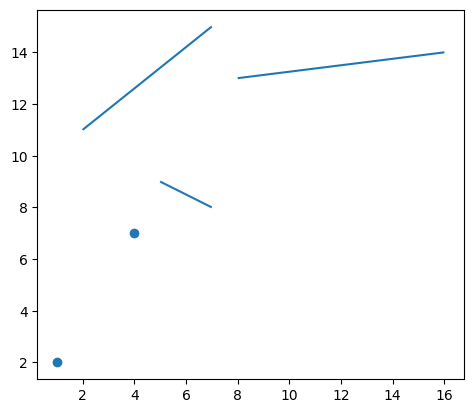

In [191]:
concat_df['geometry'].plot()

<Axes: >

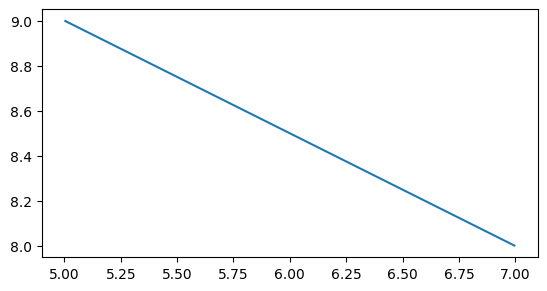

In [192]:
route_df['geometry'].plot()

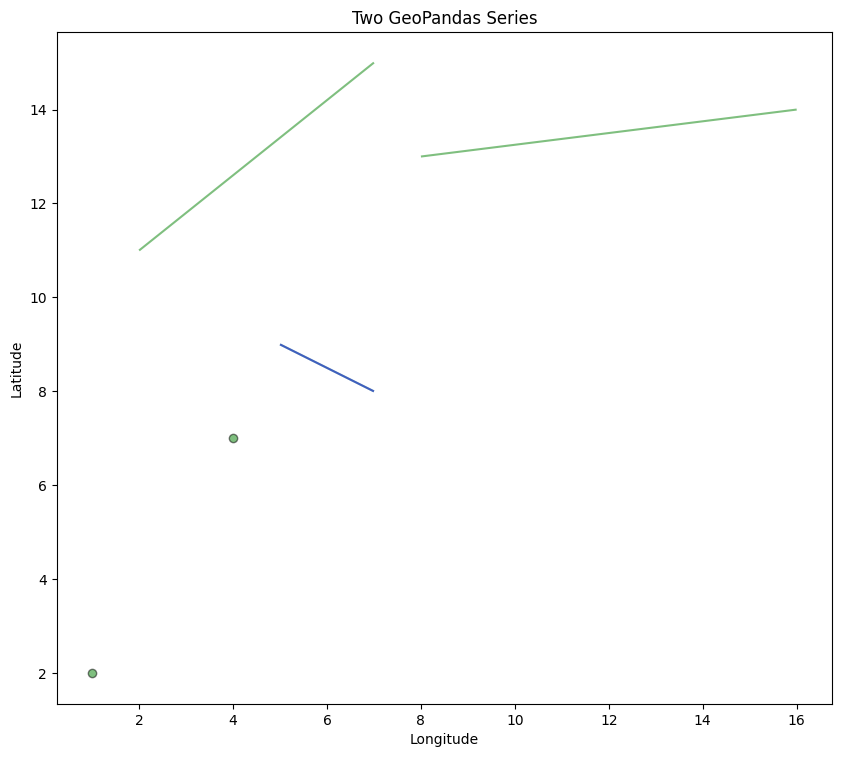

In [189]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoPandas series data
series1 = concat_df['geometry']
series2 = route_df['geometry']

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first series
series1.plot(ax=ax, color='green', alpha=0.5, edgecolor='black')

# Plot the second series
series2.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')

# Set the axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Two GeoPandas Series')

# Show the plot
plt.show()

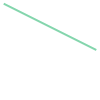

In [194]:
line1 = LineString([(7, 8), (5, 9)])
line1

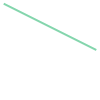

In [195]:
line2 = LineString([(7, 8), (5, 9)])
line2

In [197]:
line1.intersects(line2)

True

In [198]:
line1.overlaps(line2)

False

In [199]:
line1.overlaps

<bound method BaseGeometry.overlaps of <LINESTRING (7 8, 5 9)>>

In [201]:
from shapely.geometry import Polygon

In [209]:
nodes = table_list_gdf_nodes2['geom'].apply(lambda x: x).tolist()
nodes[:10]

[<POINT (-0.036 51.52)>,
 <POINT (-0.035 51.515)>,
 <POINT (-0.038 51.525)>,
 <POINT (6.16 49.118)>,
 <POINT (11.238 60.427)>,
 <POINT (11.238 60.428)>,
 <POINT (11.237 60.427)>,
 <POINT (11.235 60.401)>,
 <POINT (-1.38 50.899)>,
 <POINT (16.599 58.442)>]

In [214]:
for geom in nodes:
        assert isinstance(geom, Polygon), "Linestring Instantiation Error"



AssertionError: Linestring Instantiation Error

In [215]:
ways = table_list_gdf_ways2['geom'].apply(lambda x: x).tolist()
ways[:10]

[<LINESTRING (11.811 55.665, 11.811 55.665, 11.811 55.665, 11.81 55.665, 11.8...>,
 <LINESTRING (11.171 55.5, 11.172 55.499, 11.172 55.499, 11.173 55.498, 11.17...>,
 <LINESTRING (11.277 55.24, 11.277 55.24, 11.277 55.24, 11.277 55.24, 11.277 ...>,
 <LINESTRING (8.471 56.714, 8.471 56.714, 8.471 56.714, 8.471 56.714, 8.469 5...>,
 <LINESTRING (5.755 52.974, 5.755 52.974)>,
 <LINESTRING (8.557 56.688, 8.556 56.688, 8.556 56.687, 8.556 56.687, 8.556 5...>,
 <LINESTRING (8.277 56.598, 8.276 56.598, 8.274 56.598, 8.271 56.598, 8.267 5...>,
 <LINESTRING (5.615 51.941, 5.615 51.941, 5.615 51.941, 5.615 51.942, 5.615 5...>,
 <LINESTRING (8.253 56.776, 8.254 56.776, 8.254 56.776, 8.254 56.776, 8.254 5...>,
 <LINESTRING (5.603 51.898, 5.603 51.898, 5.603 51.898, 5.603 51.898, 5.603 5...>]

In [218]:
for geom in ways:
        assert isinstance(geom, Point), "Linestring Instantiation Error"



AssertionError: Linestring Instantiation Error

In [21]:
from shapely.geometry import Point, LineString

In [ ]:
pd.DataFrame(columns=['tags', 'geom'], 
             data=[[{'waterway': 'lock_gate', 'seamark:type': 'gate'},Point(5, 15)],
                   [{'seamark:type': 'harbour'},Point(9.91950, 57.06081)],
                   [{'seamark:type': 'buoy_cardinal'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_boundary'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_crossing'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_lane'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_roundabout'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_zone'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'restricted_area'},Point(12.01631, 48.92595)],                   
                   [{'seamark:type': 'separation_boundary'},LineString([(3.2738333, 51.8765), (3.154833, 51.853667)])],
                   [{'seamark:type': 'separation_crossing'},LineString([(6.3732417, 54.192091), (6.3593333, 54.1919199),(6.3310833, 54.1905871), (6.3182992, 54.189601)])],
                   [{'seamark:type': 'separation_lane'},LineString([(24.6575999, 59.6085725), (24.7026512, 59.5505585)])],
                   [{'seamark:type': 'separation_roundabout'},LineString([(27.9974563, 43.186327), (27.998524, 43.1864565),(27.9995173, 43.186412), (28.0012373, 43.1859232), (28.0020059, 43.1854689), (28.0025203, 43.1850186),(28.0029253, 43.1845006), (28.0032216, 43.1838693),(27.9947856, 43.1813859), (27.9944414, 43.1819034),(27.9941705, 43.1826993), (27.9941723, 43.1835194),(27.9944142, 43.1842511), (27.9947709, 43.1848037),(27.9953623, 43.1853841), (27.9961109, 43.1858589),(27.9974563, 43.186327)])],
                   [{'seamark:type': 'separation_zone'},LineString([(-1.9830398, 49.2927514), (-1.9830233, 49.2925889), (-1.9828257, 49.2924815), (-1.9827145, 49.2925089),(-1.9828543, 49.2927771), (-1.9830398, 49.2927514)])],
                   [{'seamark:type': 'restricted_area'},LineString([(12.3569916, 47.9186626), (12.3567217, 47.9188108),(12.3564934, 47.9189565), (12.3564734, 47.9191199),(12.3565413, 47.9192803), (12.3568636, 47.919524),(12.3571719, 47.9196858), (12.3575482, 47.9197593),(12.3579399, 47.9198024), (12.3587152, 47.9200541),(12.3594448, 47.9203064), (12.3596907, 47.9203917),(12.3599993, 47.9204654), (12.3604107, 47.9205391),(12.3608174, 47.9205554), (12.3610279, 47.9205224),(12.3612053, 47.9204511), (12.3614394, 47.9201326),(12.3616484, 47.9198195), (12.3616249, 47.9196335),(12.361631, 47.9194503), (12.3616174, 47.9193071),(12.36156, 47.9192435), (12.3614394, 47.9191936),(12.3611173, 47.9191633), (12.3609535, 47.9190676),(12.3607335, 47.9189749), (12.3604259, 47.918891),(12.3595763, 47.9187613), (12.3587674, 47.9185358),(12.3584371, 47.9183784), (12.3582044, 47.9182997),(12.3579056, 47.918306), (12.3576587, 47.9183381),(12.3573105, 47.9184692), (12.3569916, 47.9186626)])],
                  ])


In [93]:
print(filtered_gdf_seamark(table_list_gdf_ways2, 'restricted_area')['geom'].iloc[0])

LINESTRING (12.3569916 47.9186626, 12.3567217 47.9188108, 12.3564934 47.9189565, 12.3564734 47.9191199, 12.3565413 47.9192803, 12.3568636 47.919524, 12.3571719 47.9196858, 12.3575482 47.9197593, 12.3579399 47.9198024, 12.3587152 47.9200541, 12.3594448 47.9203064, 12.3596907 47.9203917, 12.3599993 47.9204654, 12.3604107 47.9205391, 12.3608174 47.9205554, 12.3610279 47.9205224, 12.3612053 47.9204511, 12.3614394 47.9201326, 12.3616484 47.9198195, 12.3616249 47.9196335, 12.361631 47.9194503, 12.3616174 47.9193071, 12.36156 47.9192435, 12.3614394 47.9191936, 12.3611173 47.9191633, 12.3609535 47.9190676, 12.3607335 47.9189749, 12.3604259 47.918891, 12.3595763 47.9187613, 12.3587674 47.9185358, 12.3584371 47.9183784, 12.3582044 47.9182997, 12.3579056 47.918306, 12.3576587 47.9183381, 12.3573105 47.9184692, 12.3569916 47.9186626)


In [38]:
table_list_gdf_nodes2['tags'].tail()

2098804    {'name': 'Bharat Petroleum', 'waterway': 'fuel...
2098805                                                   {}
2098806                                                   {}
2098807                                                   {}
2098808                                                   {}
Name: tags, dtype: object

In [39]:
table_list_gdf_nodes2.head(100)

,id,version,user_id,tstamp,changeset_id,tags,geom
0,106904,5,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03623 51.51956)
1,108735,6,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03489 51.51475)
2,110210,7,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03777 51.52499)
3,142325,5,53773,2017-04-26 14:43:20,48165623,{},POINT (6.16037 49.11819)
4,148969,14,420980,2018-10-23 11:53:56,63792931,{},POINT (11.23781 60.42730)
...,...,...,...,...,...,...,...
95,12943100,5,4948143,2019-11-20 23:16:03,77347697,"{'lock': 'yes', 'waterway': 'lock_gate', 'seam...",POINT (-1.75687 52.73175)
96,12976533,4,4948143,2019-11-20 23:16:03,77347697,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-1.79623 52.72271)
97,12976534,8,4948143,2019-11-20 23:16:03,77347697,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-1.79656 52.72260)
98,12976540,8,4948143,2019-11-20 23:16:03,77347697,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-1.79868 52.72173)


## Checking for sqlite engine connection

In [ ]:

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
from sqlalchemy import create_engine
# shapely method to convert geometry objects into their well-known-binary representation
import shapely.wkb

# sqlite/spatialite
from sqlalchemy import create_engine, event
from sqlite3 import dbapi2 as sqlite

In [ ]:
# create database engine and create sqlite database
engine = create_engine('sqlite:///gdfDB.sqlite')#, module=sqlite)

In [ ]:
nodes_gdf = gpd.GeoDataFrame(columns=['tags', 'geom'],
             data=[[{'waterway': 'lock_gate', 'seamark:type': 'gate'},Point(5, 15)],
                   [{'seamark:type': 'harbour'},Point(9.91950, 57.06081)],
                   [{'seamark:type': 'buoy_cardinal'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_boundary'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_crossing'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_lane'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_roundabout'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_zone'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'restricted_area'},Point(12.01631, 48.92595)],
                  ])

nodes_gdf

In [ ]:
nodes_df = pd.DataFrame(columns=['tags', 'geom'],
             data=[[{'waterway': 'lock_gate', 'seamark:type': 'gate'},Point(5, 15)],
                   [{'seamark:type': 'harbour'},Point(9.91950, 57.06081)],
                   [{'seamark:type': 'buoy_cardinal'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_boundary'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_crossing'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_lane'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_roundabout'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'separation_zone'},Point(12.01631, 48.92595)],
                   [{'seamark:type': 'restricted_area'},Point(12.01631, 48.92595)],
                  ])

nodes_df

In [ ]:
ways_gdf = gpd.GeoDataFrame(columns=['tags', 'geom'],
             data=[
                   [{'seamark:type': 'separation_boundary'},LineString([(3.2738333, 51.8765), (3.154833, 51.853667)])],
                   [{'seamark:type': 'separation_crossing'},LineString([(6.3732417, 54.192091), (6.3593333, 54.1919199),(6.3310833, 54.1905871), (6.3182992, 54.189601)])],
                   [{'seamark:type': 'separation_lane'},LineString([(24.6575999, 59.6085725), (24.7026512, 59.5505585)])],
                   [{'seamark:type': 'separation_roundabout'},LineString([(27.9974563, 43.186327), (27.998524, 43.1864565),(27.9995173, 43.186412), (28.0012373, 43.1859232), (28.0020059, 43.1854689), (28.0025203, 43.1850186),(28.0029253, 43.1845006), (28.0032216, 43.1838693),(27.9947856, 43.1813859), (27.9944414, 43.1819034),(27.9941705, 43.1826993), (27.9941723, 43.1835194),(27.9944142, 43.1842511), (27.9947709, 43.1848037),(27.9953623, 43.1853841), (27.9961109, 43.1858589),(27.9974563, 43.186327)])],
                   [{'seamark:type': 'separation_zone'},LineString([(-1.9830398, 49.2927514), (-1.9830233, 49.2925889), (-1.9828257, 49.2924815), (-1.9827145, 49.2925089),(-1.9828543, 49.2927771), (-1.9830398, 49.2927514)])],
                   [{'seamark:type': 'restricted_area'},LineString([(12.3569916, 47.9186626), (12.3567217, 47.9188108),(12.3564934, 47.9189565), (12.3564734, 47.9191199),(12.3565413, 47.9192803), (12.3568636, 47.919524),(12.3571719, 47.9196858), (12.3575482, 47.9197593),(12.3579399, 47.9198024), (12.3587152, 47.9200541),(12.3594448, 47.9203064), (12.3596907, 47.9203917),(12.3599993, 47.9204654), (12.3604107, 47.9205391),(12.3608174, 47.9205554), (12.3610279, 47.9205224),(12.3612053, 47.9204511), (12.3614394, 47.9201326),(12.3616484, 47.9198195), (12.3616249, 47.9196335),(12.361631, 47.9194503), (12.3616174, 47.9193071),(12.36156, 47.9192435), (12.3614394, 47.9191936),(12.3611173, 47.9191633), (12.3609535, 47.9190676),(12.3607335, 47.9189749), (12.3604259, 47.918891),(12.3595763, 47.9187613), (12.3587674, 47.9185358),(12.3584371, 47.9183784), (12.3582044, 47.9182997),(12.3579056, 47.918306), (12.3576587, 47.9183381),(12.3573105, 47.9184692), (12.3569916, 47.9186626)])],
                  ])

ways_gdf

In [ ]:
ways_df = pd.DataFrame(columns=['tags', 'geom'],
             data=[
                   [{'seamark:type': 'separation_boundary'},LineString([(3.2738333, 51.8765), (3.154833, 51.853667)])],
                   [{'seamark:type': 'separation_crossing'},LineString([(6.3732417, 54.192091), (6.3593333, 54.1919199),(6.3310833, 54.1905871), (6.3182992, 54.189601)])],
                   [{'seamark:type': 'separation_lane'},LineString([(24.6575999, 59.6085725), (24.7026512, 59.5505585)])],
                   [{'seamark:type': 'separation_roundabout'},LineString([(27.9974563, 43.186327), (27.998524, 43.1864565),(27.9995173, 43.186412), (28.0012373, 43.1859232), (28.0020059, 43.1854689), (28.0025203, 43.1850186),(28.0029253, 43.1845006), (28.0032216, 43.1838693),(27.9947856, 43.1813859), (27.9944414, 43.1819034),(27.9941705, 43.1826993), (27.9941723, 43.1835194),(27.9944142, 43.1842511), (27.9947709, 43.1848037),(27.9953623, 43.1853841), (27.9961109, 43.1858589),(27.9974563, 43.186327)])],
                   [{'seamark:type': 'separation_zone'},LineString([(-1.9830398, 49.2927514), (-1.9830233, 49.2925889), (-1.9828257, 49.2924815), (-1.9827145, 49.2925089),(-1.9828543, 49.2927771), (-1.9830398, 49.2927514)])],
                   [{'seamark:type': 'restricted_area'},LineString([(12.3569916, 47.9186626), (12.3567217, 47.9188108),(12.3564934, 47.9189565), (12.3564734, 47.9191199),(12.3565413, 47.9192803), (12.3568636, 47.919524),(12.3571719, 47.9196858), (12.3575482, 47.9197593),(12.3579399, 47.9198024), (12.3587152, 47.9200541),(12.3594448, 47.9203064), (12.3596907, 47.9203917),(12.3599993, 47.9204654), (12.3604107, 47.9205391),(12.3608174, 47.9205554), (12.3610279, 47.9205224),(12.3612053, 47.9204511), (12.3614394, 47.9201326),(12.3616484, 47.9198195), (12.3616249, 47.9196335),(12.361631, 47.9194503), (12.3616174, 47.9193071),(12.36156, 47.9192435), (12.3614394, 47.9191936),(12.3611173, 47.9191633), (12.3609535, 47.9190676),(12.3607335, 47.9189749), (12.3604259, 47.918891),(12.3595763, 47.9187613), (12.3587674, 47.9185358),(12.3584371, 47.9183784), (12.3582044, 47.9182997),(12.3579056, 47.918306), (12.3576587, 47.9183381),(12.3573105, 47.9184692), (12.3569916, 47.9186626)])],
                  ])

ways_df

In [7]:
engine

Engine(sqlite:///gdfDB.sqlite)

In [11]:
nodes_df.to_sql('nodes',con=engine,if_exists='replace')

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 1 - probably unsupported type.
[SQL: INSERT INTO nodes ("index", tags, geom) VALUES (?, ?, ?)]
[parameters: [(0, {'waterway': 'lock_gate', 'seamark:type': 'gate'}, <POINT (5 15)>), (1, {'seamark:type': 'harbour'}, <POINT (9.92 57.061)>), (2, {'seamark:type': 'buoy_cardinal'}, <POINT (12.016 48.926)>), (3, {'seamark:type': 'separation_boundary'}, <POINT (12.016 48.926)>), (4, {'seamark:type': 'separation_crossing'}, <POINT (12.016 48.926)>), (5, {'seamark:type': 'separation_lane'}, <POINT (12.016 48.926)>), (6, {'seamark:type': 'separation_roundabout'}, <POINT (12.016 48.926)>), (7, {'seamark:type': 'separation_zone'}, <POINT (12.016 48.926)>), (8, {'seamark:type': 'restricted_area'}, <POINT (12.016 48.926)>)]]
(Background on this error at: https://sqlalche.me/e/20/rvf5)

In [23]:
nodes_gdf = nodes_gdf.set_geometry('geom') 
nodes_gdf.to_file('gdfDB.sqlite', driver='SQLite', spatialite=True, layer='nodes',set_geometry='geom')

In [24]:
ways_gdf = ways_gdf.set_geometry('geom') 
ways_gdf.to_file('gdfDB.sqlite', driver='SQLite', spatialite=True, layer='ways')

In [25]:
pd.read_sql('select * from nodes',con=engine)#'sqlite:///gdfDB.sqlite')

,ogc_fid,GEOMETRY,tags
0,1,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...,"{""waterway"": ""lock_gate"", ""seamark:type"": ""gate""}"
1,2,b'\x01\x01\x00\x00\x00\x10X9\xb4\xc8\xd6#@\x87...,"{""seamark:type"": ""harbour""}"
2,3,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""buoy_cardinal""}"
3,4,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_boundary""}"
4,5,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_crossing""}"
5,6,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_lane""}"
6,7,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_roundabout""}"
7,8,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_zone""}"
8,9,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""restricted_area""}"


In [26]:
pd.read_sql('select * from ways',con=engine)#'sqlite:///gdfDB.sqlite')

,ogc_fid,GEOMETRY,tags
0,1,b'\x01\x02\x00\x00\x00\x02\x00\x00\x001r`\x83\...,"{""seamark:type"": ""separation_boundary""}"
1,2,"b""\x01\x02\x00\x00\x00\x04\x00\x00\x00\x87\x03...","{""seamark:type"": ""separation_crossing""}"
2,3,b'\x01\x02\x00\x00\x00\x02\x00\x00\x00VZ\x90wX...,"{""seamark:type"": ""separation_lane""}"
3,4,b'\x01\x02\x00\x00\x00\x11\x00\x00\x00m\xb0\xc...,"{""seamark:type"": ""separation_roundabout""}"
4,5,b'\x01\x02\x00\x00\x00\x06\x00\x00\x00\x7f\xa9...,"{""seamark:type"": ""separation_zone""}"
5,6,b'\x01\x02\x00\x00\x00$\x00\x00\x00\xb8\xe4]\x...,"{""seamark:type"": ""restricted_area""}"


In [27]:
gpd.read_postgis('select *,geometry as geom FROM nodes',con =engine,geom_col='geom').drop(['GEOMETRY'],axis=1)

,ogc_fid,tags,geom
0,1,"{""waterway"": ""lock_gate"", ""seamark:type"": ""gate""}",POINT (5.00000 15.00000)
1,2,"{""seamark:type"": ""harbour""}",POINT (9.91950 57.06081)
2,3,"{""seamark:type"": ""buoy_cardinal""}",POINT (12.01631 48.92595)
3,4,"{""seamark:type"": ""separation_boundary""}",POINT (12.01631 48.92595)
4,5,"{""seamark:type"": ""separation_crossing""}",POINT (12.01631 48.92595)
5,6,"{""seamark:type"": ""separation_lane""}",POINT (12.01631 48.92595)
6,7,"{""seamark:type"": ""separation_roundabout""}",POINT (12.01631 48.92595)
7,8,"{""seamark:type"": ""separation_zone""}",POINT (12.01631 48.92595)
8,9,"{""seamark:type"": ""restricted_area""}",POINT (12.01631 48.92595)


In [28]:
gpd.read_postgis('select *,geometry as geom FROM ways',con =engine,geom_col='geom').drop(['GEOMETRY'],axis=1)

,ogc_fid,tags,geom
0,1,"{""seamark:type"": ""separation_boundary""}","LINESTRING (3.27383 51.87650, 3.15483 51.85367)"
1,2,"{""seamark:type"": ""separation_crossing""}","LINESTRING (6.37324 54.19209, 6.35933 54.19192..."
2,3,"{""seamark:type"": ""separation_lane""}","LINESTRING (24.65760 59.60857, 24.70265 59.55056)"
3,4,"{""seamark:type"": ""separation_roundabout""}","LINESTRING (27.99746 43.18633, 27.99852 43.186..."
4,5,"{""seamark:type"": ""separation_zone""}","LINESTRING (-1.98304 49.29275, -1.98302 49.292..."
5,6,"{""seamark:type"": ""restricted_area""}","LINESTRING (12.35699 47.91866, 12.35672 47.918..."


In [40]:
type(engine.connect())

sqlalchemy.engine.base.Connection

In [45]:
sqlite.connect('gdfDB.sqlite')

In [7]:
gpd.read_postgis('select *,geometry as geom FROM nodes',con =engine.connect(),geom_col='geom')

,index,tags,geometry,geom


In [8]:
nodes_df['geometry']= nodes_df.apply(lambda x: shapely.wkb.dumps(x.geometry), axis=1)


In [9]:
nodes_df.to_sql('nodes',con=engine.connect(),if_exists='replace')

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 1 - probably unsupported type.
[SQL: INSERT INTO nodes ("index", tags, geometry) VALUES (?, ?, ?)]
[parameters: [(0, {'waterway': 'lock_gate', 'seamark:type': 'gate'}, b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14@\x00\x00\x00\x00\x00\x00.@'), (1, {'seamark:type': 'harbour'}, b'\x01\x01\x00\x00\x00\x10X9\xb4\xc8\xd6#@\x87\xa2@\x9f\xc8\x87L@'), (2, {'seamark:type': 'buoy_cardinal'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (3, {'seamark:type': 'separation_boundary'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (4, {'seamark:type': 'separation_crossing'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (5, {'seamark:type': 'separation_lane'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (6, {'seamark:type': 'separation_roundabout'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (7, {'seamark:type': 'separation_zone'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (8, {'seamark:type': 'restricted_area'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@')]]
(Background on this error at: https://sqlalche.me/e/20/rvf5)

In [15]:
nodes_df

,tags,geometry
0,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...
1,{'seamark:type': 'harbour'},b'\x01\x01\x00\x00\x00\x10X9\xb4\xc8\xd6#@\x87...
2,{'seamark:type': 'buoy_cardinal'},b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...
3,{'seamark:type': 'separation_boundary'},b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...
4,{'seamark:type': 'separation_crossing'},b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...
5,{'seamark:type': 'separation_lane'},b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...
6,{'seamark:type': 'separation_roundabout'},b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...
7,{'seamark:type': 'separation_zone'},b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...
8,{'seamark:type': 'restricted_area'},b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...


In [19]:
 # convert all values from the geopandas geometry column into their well-known-binary representations
nodes_df['geometry'] = nodes_df.apply(lambda x: shapely.wkb.dumps(x.geometry), axis=1)

/home/igor/projects/maridata/MariGeoRoute/data/OpenSeaMap/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [22]:
nodes_df.to_sql('nodes',con=engine)

InterfaceError: (sqlite3.InterfaceError) Error binding parameter 1 - probably unsupported type.
[SQL: INSERT INTO nodes ("index", tags, geometry) VALUES (?, ?, ?)]
[parameters: [(0, {'waterway': 'lock_gate', 'seamark:type': 'gate'}, b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14@\x00\x00\x00\x00\x00\x00.@'), (1, {'seamark:type': 'harbour'}, b'\x01\x01\x00\x00\x00\x10X9\xb4\xc8\xd6#@\x87\xa2@\x9f\xc8\x87L@'), (2, {'seamark:type': 'buoy_cardinal'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (3, {'seamark:type': 'separation_boundary'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (4, {'seamark:type': 'separation_crossing'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (5, {'seamark:type': 'separation_lane'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (6, {'seamark:type': 'separation_roundabout'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (7, {'seamark:type': 'separation_zone'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@'), (8, {'seamark:type': 'restricted_area'}, b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98\xdd\x93\x87\x85vH@')]]
(Background on this error at: https://sqlalche.me/e/20/rvf5)

In [8]:
nodes_gdf.to_file('gdfDB.sqlite', driver='SQLite', spatialite=True, layer='nodes')

In [9]:
type(nodes_gdf)

geopandas.geodataframe.GeoDataFrame

In [10]:
gpd.read_file('gdfDB.sqlite')

,tags,geometry
0,"{""waterway"": ""lock_gate"", ""seamark:type"": ""gate""}",POINT (5.00000 15.00000)
1,"{""seamark:type"": ""harbour""}",POINT (9.91950 57.06081)
2,"{""seamark:type"": ""buoy_cardinal""}",POINT (12.01631 48.92595)
3,"{""seamark:type"": ""separation_boundary""}",POINT (12.01631 48.92595)
4,"{""seamark:type"": ""separation_crossing""}",POINT (12.01631 48.92595)
5,"{""seamark:type"": ""separation_lane""}",POINT (12.01631 48.92595)
6,"{""seamark:type"": ""separation_roundabout""}",POINT (12.01631 48.92595)
7,"{""seamark:type"": ""separation_zone""}",POINT (12.01631 48.92595)
8,"{""seamark:type"": ""restricted_area""}",POINT (12.01631 48.92595)


In [2]:
# create database engine and create sqlite database
engine = create_engine('sqlite:///TestDB.sqlite', module=sqlite)

In [3]:
engine.connect()

In [145]:
nodes_df.to_file('dataframe.sqlite', driver='SQLite', spatialite=True, layer='nodes')

In [12]:
import sqlite3
import shapely

In [28]:
@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite.dll")')

# create spatialite metadata
print('creating spatial metadata...')
engine.connect()#.execute("SELECT InitSpatialMetaData(1);")

creating spatial metadata...


OperationalError: (sqlite3.OperationalError) mod_spatialite.dll.so: cannot open shared object file: No such file or directory
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [24]:
gpd.read_postgis('SELECT *, geometry as geometry FROM nodes', con=engine,geom_col='geometry').drop(['GEOMETRY'], axis=1)

OperationalError: (sqlite3.OperationalError) mod_spatialite.dll.so: cannot open shared object file: No such file or directory
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [23]:
conn = sqlite3.connect('gdfDB.sqlite')
conn

In [19]:
gpd.read_postgis('SELECT *, geometry as geometry FROM nodes', con=conn,geom_col='geometry').drop(['GEOMETRY'], axis=1)

,ogc_fid,tags,geometry
0,1,"{""waterway"": ""lock_gate"", ""seamark:type"": ""gate""}",POINT (5.00000 15.00000)
1,2,"{""seamark:type"": ""harbour""}",POINT (9.91950 57.06081)
2,3,"{""seamark:type"": ""buoy_cardinal""}",POINT (12.01631 48.92595)
3,4,"{""seamark:type"": ""separation_boundary""}",POINT (12.01631 48.92595)
4,5,"{""seamark:type"": ""separation_crossing""}",POINT (12.01631 48.92595)
5,6,"{""seamark:type"": ""separation_lane""}",POINT (12.01631 48.92595)
6,7,"{""seamark:type"": ""separation_roundabout""}",POINT (12.01631 48.92595)
7,8,"{""seamark:type"": ""separation_zone""}",POINT (12.01631 48.92595)
8,9,"{""seamark:type"": ""restricted_area""}",POINT (12.01631 48.92595)


In [147]:
conn

In [139]:
gdf = pd.read_sql('SELECT * FROM nodes', conn)
gdf.rename(columns={'GEOMETRY':'geom'}, inplace=True)
gdf

,ogc_fid,geom,tags
0,1,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...,"{""waterway"": ""lock_gate"", ""seamark:type"": ""gate""}"
1,2,b'\x01\x01\x00\x00\x00\x10X9\xb4\xc8\xd6#@\x87...,"{""seamark:type"": ""harbour""}"
2,3,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""buoy_cardinal""}"
3,4,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_boundary""}"
4,5,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_crossing""}"
5,6,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_lane""}"
6,7,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_roundabout""}"
7,8,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""separation_zone""}"
8,9,b'\x01\x01\x00\x00\x00\x0e2\xc9\xc8Y\x08(@\x98...,"{""seamark:type"": ""restricted_area""}"


In [135]:
gdf['geom'] = gdf.apply(lambda x: shapely.wkb.dumps(x.geom), axis=1)

TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

In [17]:
seamark_object = ['ways', 'nodes']
seamark_list = ['separation_line','separation_zone']
tags = ['separation_zone', 'separation_line', 'separation_lane', 'restricted_area' ,'separation_roundabout']

In [25]:
if ("nodes" in seamark_object) and ("ways" in seamark_object) and all(element in tags for element in seamark_list):
    gdf = pd.concat([table_list_gdf_nodes2, table_list_gdf_ways2])
    print(gdf['tags'].iloc[0])
    gdf_list = []
    for i in range(0, len(seamark_list)):

        if type(gdf['tags'].iloc[i]) == str:
            print(gdf['tags'].iloc[i])
            gdf['tags'] = gdf['tags'].apply(ast.literal_eval)
            gdf1 = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
            gdf_list.append(gdf1)
        else:
            gdf1 = gdf[gdf['tags'].apply(lambda x: seamark_list[i] in x.values())]
            gdf_list.append(gdf1)


    gdf_concat = pd.concat(gdf_list)
    
gdf_concat





{'waterway': 'lock_gate', 'seamark:type': 'gate'}


,id,version,user_id,tstamp,changeset_id,tags,geom,geometry,nodes,linestring
429,173232538,1,84409,2012-07-28 07:15:40,12519538,{'seamark:type': 'separation_line'},"LINESTRING (24.4507557 59.4998465, 24.5000132 ...",None,"[1840889314, 1840889316]",0102000020E6100000020000004FFCBDB9647338409142...
5461,112191577,1,128186,2011-05-07 18:09:08,8075573,{'seamark:type': 'separation_line'},"LINESTRING (0.1607495 53.5454742, 0.118768 53....",None,"[838703657, 838703660]",0102000020E610000002000000CC96AC8A7093C43FE8E7...
5466,112284719,1,128186,2011-05-08 05:42:39,8079069,{'seamark:type': 'separation_line'},"LINESTRING (0.18577 53.544467, 0.219933 53.54697)",None,"[838043893, 838042689]",0102000020E61000000200000048F949B54FC7C73F2860...
5469,112284722,1,128186,2011-05-08 05:42:39,8079069,{'seamark:type': 'separation_line'},"LINESTRING (0.290783 53.520617, 0.346667 53.49...",None,"[863140180, 863865058]",0102000020E610000002000000ACE5CE4C309CD23FEE5E...
5477,112284730,1,128186,2011-05-08 05:42:40,8079069,{'seamark:type': 'separation_line'},"LINESTRING (0.2844895 53.574609, 0.3442118 53....",None,"[1276680173, 1276680131, 1276680154]",0102000020E6100000030000008B8BA3721335D23F5F7E...
...,...,...,...,...,...,...,...,...,...,...
100034,1119383483,3,715936,2022-12-12 21:51:47,130013989,"{'seamark:type': 'separation_zone', 'seamark:s...","LINESTRING (5.333408 59.081983, 5.3335942 59.0...",None,"[10237995346, 10237995345, 10237995344, 102379...",0102000020E61000005D0000002AE620E868551540FBE9...
100036,1119383485,2,715936,2022-12-12 21:51:47,130013989,"{'seamark:type': 'separation_zone', 'seamark:s...","LINESTRING (5.296011 59.0686527, 5.2326894 59....",None,"[10237995371, 10237995370, 10237995368, 102379...",0102000020E6100000060000006806F1811D2F15401CA4...
100041,1119383490,2,715936,2022-12-12 21:51:47,130013989,"{'seamark:type': 'separation_zone', 'seamark:s...","LINESTRING (5.3279078 59.0199617, 5.3190672 59...",None,"[10237995361, 10237995360, 10237995359, 102379...",0102000020E610000005000000CA69F40FC74F15401756...
101671,1154194855,1,78466,2023-03-14 07:44:40,133654069,{'seamark:name': 'TSS Off Neist Point in the M...,"LINESTRING (-6.9165 57.3988333, -6.8888333 57....",None,"[10734305570, 10734305575, 10734305574, 107343...",0102000020E610000007000000D122DBF97EAA1BC02307...


In [24]:
pd.concat([table_list_gdf_nodes2, table_list_gdf_ways2])['']

,id,version,user_id,tstamp,changeset_id,tags,geom,geometry,nodes,linestring
0,106904,5,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",0101000020E61000000E1714611E8DA2BF53FBBEC980C2...,POINT (-0.03623 51.51956),NaN,NaN
1,108735,6,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",0101000020E61000007FA6B9707BDDA1BF3EDC1F39E3C1...,POINT (-0.03489 51.51475),NaN,NaN
2,110210,7,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",0101000020E6100000B12C3D3F3157A3BFAA4F28FA32C3...,POINT (-0.03777 51.52499),NaN,NaN
3,142325,5,53773,2017-04-26 14:43:20,48165623,{},0101000020E6100000969E44DF38A41840E3D3ADE8208F...,POINT (6.16037 49.11819),NaN,NaN
4,148969,14,420980,2018-10-23 11:53:56,63792931,{},0101000020E61000002651D43EC279264004CCD7C0B136...,POINT (11.23781 60.42730),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
102503,1173235725,1,449569,2023-05-16 08:38:33,136157239,"{'seamark:type': 'small_craft_facility', 'seam...","LINESTRING (-92.4506241 42.5399962, -92.450676...",None,"[10901378809, 10901378833]",0102000020E61000000200000086127706D71C57C06D7B...
102504,1173235727,1,449569,2023-05-16 08:38:33,136157239,"{'highway': 'service', 'seamark:type': 'small_...","LINESTRING (-92.4506056 42.5400255, -92.450624...",None,"[10901378834, 10901378809]",0102000020E6100000020000003FD9DEB8D61C57C0C6C0...
102505,1173238209,1,449569,2023-05-16 08:51:33,136157823,"{'seamark:type': 'small_craft_facility', 'seam...","LINESTRING (-92.4337828 42.5298889, -92.433710...",None,"[10901366558, 10901366559]",0102000020E6100000020000004FE4EE18C31B57C0B801...
102506,1173400995,2,17531229,2023-05-16 17:31:40,136179862,"{'name': 'Бейбарс Газ', 'building': 'yes', 'wa...","LINESTRING (69.4201454 42.4884203, 69.4202495 ...",None,"[10902512013, 10902512014, 10902512015, 109025...",0102000020E610000005000000262488A9E35A5140EC99...


In [22]:
gdf['tags'].iloc[i]

NameError: name 'gdf' is not defined

In [1]:
import numpy as np

In [2]:
x = np.random.randint(1, 100, 5)
x

array([98,  4, 17, 43, 79])

In [3]:
type(x)

numpy.ndarray

In [4]:
len(x)

5

In [5]:
x[1]

4

In [7]:
for i in range(len(x)):
    print(i)

0
1
2
3
4


In [9]:
from shapely.geometry import Point, LineString

In [10]:
'nodes' in ['nodes','ways']

True

In [13]:
set(['a','c']).issubset(['a','b'])

False

In [2]:
import sqlalchemy
import geopandas as gpd
import folium

In [29]:
!pip install folium mapclassify

  Using cached mapclassify-2.5.0-py3-none-any.whl (39 kB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)


In [3]:
engine = sqlalchemy.create_engine(
    "postgresql://{user}:{pw}@{host}/{db}".format(
                user='myuser',
                pw='mypassword',
                host='172.22.0.3',
                db='mydatabase',
                port=5432)
)

In [4]:
gdf = gpd.read_postgis(con=engine, 
                sql='SELECT * FROM nodes')

In [5]:
gdf.head()

,id,version,user_id,tstamp,changeset_id,tags,geom
0,106904,5,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03623 51.51956)
1,108735,6,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03489 51.51475)
2,110210,7,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03777 51.52499)
3,142325,5,53773,2017-04-26 14:43:20,48165623,{},POINT (6.16037 49.11819)
4,148969,14,420980,2018-10-23 11:53:56,63792931,{},POINT (11.23781 60.42730)


In [25]:
gdf_seamark_combined(['nodes','ways'],['separation_line','separation_zone'])

Check the seamark object and seamark tag list


UnboundLocalError: local variable 'gdf_concat' referenced before assignment

##############################################################################################

In [16]:
gdf.drop(columns=['tstamp'], inplace=True)

In [18]:
def concat_nodes_ways():
    gdf = pd.concat([table_list_gdf_nodes2,table_list_gdf_ways2])
    
    gdf = gdf[gdf["geom"] != None]
    
    return gdf

In [19]:
concat_nodes_ways()

,id,version,user_id,tstamp,changeset_id,tags,geom,nodes,linestring
0,106904,5,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03623 51.51956),NaN,NaN
1,108735,6,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03489 51.51475),NaN,NaN
2,110210,7,4948143,2020-06-15 19:23:35,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03777 51.52499),NaN,NaN
3,142325,5,53773,2017-04-26 14:43:20,48165623,{},POINT (6.16037 49.11819),NaN,NaN
4,148969,14,420980,2018-10-23 11:53:56,63792931,{},POINT (11.23781 60.42730),NaN,NaN
...,...,...,...,...,...,...,...,...,...
103919,1189004157,1,124870,2023-07-11 21:48:37,138396881,"{'place': 'islet', 'natural': 'coastline', 'se...","LINESTRING (20.21404 59.92802, 20.21401 59.928...","[11040467716, 11040467715, 11040467714, 110404...",0102000020E61000001D00000033B21A01CB36344034B8...
103920,1189004158,1,124870,2023-07-11 21:48:37,138396881,"{'seamark:type': 'obstruction', 'seamark:obstr...","LINESTRING (20.20830 59.92634, 20.20831 59.926...","[11040467723, 11040467722, 11040467721, 110404...",0102000020E610000008000000641AF27453353440B583...
103921,1189004159,1,124870,2023-07-11 21:48:37,138396881,"{'seamark:type': 'obstruction', 'seamark:obstr...","LINESTRING (20.20745 59.92661, 20.20746 59.926...","[11040467733, 11040467732, 11040467731, 110404...",0102000020E61000000800000099068F801B35344016E3...
103922,1189004571,1,124870,2023-07-11 21:52:06,138396972,"{'place': 'islet', 'natural': 'coastline', 'se...","LINESTRING (20.21543 59.92796, 20.21547 59.927...","[11040461987, 11040461986, 11040461985, 110404...",0102000020E61000001A000000DAFE959526373440534D...


In [20]:
def gdf_seamark_combined_nodes_ways():
    """
     Create new GeoDataFrame with specified seamark tags

     Parameters
     ----------
     engine : sqlalchemy engine
         engine object

     query : list
         list of str for the sql query for table nodes and ways

     seamark_object : list
        value nodes, ways (which table to be considered)

     seamark_list : list
         list of all the tags that must be considered for filtering specific seamark objects


     Returns
     ----------
     gdf_concat : GeoDataFrame
         gdf including all the features with specified seamark tags using nodes and ways OSM element
     """
    # gdf_concat = gpd.GeoDataFrame()
    seamark_list = ["separation_line", "separation_zone", "restricted_areas"]

    if ("nodes" in ["nodes","ways"]) and ("ways" in ["nodes","ways"]): #and set(seamark_list).issubset(self.tags):
        gdf = concat_nodes_ways()

        gdf_list = []
        for i in range(0, len(seamark_list)):
            if type(gdf["tags"].iloc[i]) == str:
                gdf["tags"] = gdf["tags"].apply(ast.literal_eval)
                gdf1 = gdf[
                    gdf["tags"].apply(lambda x: seamark_list[i] in x.values())
                ]
                gdf_list.append(gdf1)
            else:
                gdf1 = gdf[
                    gdf["tags"].apply(lambda x: seamark_list[i] in x.values())
                ]
                gdf_list.append(gdf1)

        gdf_concat = pd.concat(gdf_list)
        print(f'concat geodataframe is {gdf_concat}')
    else:
        gdf_concat = gpd.GeoDataFrame()
        print(f' error concat geodataframe is {gdf_concat}')
        logger.info("Check the seamark object and seamark tag list")

    return gdf_concat

    

In [21]:
gdf_seamark_combined_nodes_ways()

concat geodataframe is                 id  version   user_id               tstamp  changeset_id   
9        112284719        1    128186  2011-05-08 05:42:39       8079069  \
91       112284722        1    128186  2011-05-08 05:42:39       8079069   
2265     112284730        1    128186  2011-05-08 05:42:40       8079069   
2276     112284731        1    128186  2011-05-08 05:42:40       8079069   
3334     171432787        2     84409  2012-07-28 07:19:42      12519566   
...            ...      ...       ...                  ...           ...   
102890  1175018154        1  18777513  2023-05-22 11:25:21     136408613   
102891  1175018155        1  18777513  2023-05-22 11:25:21     136408613   
102896  1175018160        1  18777513  2023-05-22 11:25:21     136408613   
102897  1175018161        1  18777513  2023-05-22 11:25:21     136408613   
102898  1175018162        1  18777513  2023-05-22 11:25:21     136408613   

                                       tags   
9       {'seamark

,id,version,user_id,tstamp,changeset_id,tags,geom,nodes,linestring
9,112284719,1,128186,2011-05-08 05:42:39,8079069,{'seamark:type': 'separation_line'},"LINESTRING (0.18577 53.54447, 0.21993 53.54697)","[838043893, 838042689]",0102000020E61000000200000048F949B54FC7C73F2860...
91,112284722,1,128186,2011-05-08 05:42:39,8079069,{'seamark:type': 'separation_line'},"LINESTRING (0.29078 53.52062, 0.34667 53.49817)","[863140180, 863865058]",0102000020E610000002000000ACE5CE4C309CD23FEE5E...
2265,112284730,1,128186,2011-05-08 05:42:40,8079069,{'seamark:type': 'separation_line'},"LINESTRING (0.28449 53.57461, 0.34421 53.61661...","[1276680173, 1276680131, 1276680154]",0102000020E6100000030000008B8BA3721335D23F5F7E...
2276,112284731,1,128186,2011-05-08 05:42:40,8079069,{'seamark:type': 'separation_line'},"LINESTRING (0.30492 53.54530, 0.38267 53.54533)","[863140151, 863864734]",0102000020E610000002000000C6A4BF97C283D33F2041...
3334,171432787,2,84409,2012-07-28 07:19:42,12519566,{'seamark:type': 'separation_line'},"LINESTRING (28.35444 60.47129, 28.35452 60.54584)","[1824599580, 1824600922]",0102000020E6100000020000007CF1457BBC5A3C40AC84...
...,...,...,...,...,...,...,...,...,...
102890,1175018154,1,18777513,2023-05-22 11:25:21,136408613,{'seamark:type': 'separation_zone'},"LINESTRING (-6.65783 50.04217, -6.70833 50.051...","[10918123277, 10918123280, 10918123279, 109181...",0102000020E61000000500000008E1760D9FA11AC079BD...
102891,1175018155,1,18777513,2023-05-22 11:25:21,136408613,{'seamark:type': 'separation_zone'},"LINESTRING (-6.61217 49.87367, -6.54633 50.021...","[10918123281, 10918123284, 10918123283, 109181...",0102000020E6100000050000000DCDD0D3DB721AC0580D...
102896,1175018160,1,18777513,2023-05-22 11:25:21,136408613,{'seamark:type': 'separation_zone'},"LINESTRING (-6.27667 49.60933, -6.56167 49.609...","[10918123291, 10918123294, 10918123293, 109181...",0102000020E610000005000000A891F1834E1B19C090EE...
102897,1175018161,1,18777513,2023-05-22 11:25:21,136408613,{'seamark:type': 'separation_zone'},"LINESTRING (-6.27667 49.69250, -6.52450 49.692...","[10918123295, 10918123298, 10918123297, 109181...",0102000020E610000005000000A891F1834E1B19C0713D...


In [22]:
from shapely.geometry import Point,LineString
from shapely import STRtree

In [52]:
def check_crossing(lat_start, lon_start, lat_end, lon_end,
                       time=None):  # best way to go (keep just these arguments)
        """
         Check if certain route crosses specified seamark objects

         Parameters
         ----------
         lat_start : np.array
            array of all origin latitudes of routing segments

        lon_start : np.array
            array of all origin longitudes of routing segments

         lat_end : np.array
            array of all destination latitudes of routing segments

        lon_end : np.array
            array of all destination longitudes of routing segments

         time : datetime.datetime (optional argument)

         Returns
         ----------
         query_tree : list
             bool of spatial relation result (True or False)
         """

        query_tree = []

        concat_gdf = gdf_seamark_combined_nodes_ways()
        print(concat_gdf.head())
        lines = []

        # generating the LineString geometry from start and end point
        print(type(lat_start))
        #for i in range(len(lat_start)):
        #start_point = Point(lat_start, lon_start)
        start_point = Point(lon_start,lat_start)
#         print(start_point.x)
#         print(start_point.y)
        end_point = Point(lon_end,lat_end)
        line = LineString([start_point, end_point])
        # start_point = Point(lon_start[i], lat_start[i])
        # end_point = Point(lon_end[i], lat_end[i])
        # line = LineString([start_point, end_point])
        lines.append(line)

        # creating geospatial dataframe objects from linestring geometries
        route_df = gpd.GeoDataFrame(geometry=lines)

        # checking the spatial relations using shapely.STRTree spatial indexing method
        #for predicate in self.predicates:
        concat_df = concat_gdf
        tree = STRtree(concat_df["geom"])
        geom_object = tree.query(route_df["geometry"], predicate='contains').tolist()

        # checks if there is spatial relation between routes and seamarks objects
        if geom_object == [[], []] or geom_object == []:
            # if route is not constrained
            query_tree.append(False)
        else:
            # if route is constrained
            query_tree.append(True)

        # returns a list bools (spatial relation)
        return query_tree

In [56]:
check_crossing(50.5545, 0.267850.7938, 0.4504,
                       time=None)

concat geodataframe is                 id  version   user_id               tstamp  changeset_id   
9        112284719        1    128186  2011-05-08 05:42:39       8079069  \
91       112284722        1    128186  2011-05-08 05:42:39       8079069   
2265     112284730        1    128186  2011-05-08 05:42:40       8079069   
2276     112284731        1    128186  2011-05-08 05:42:40       8079069   
3334     171432787        2     84409  2012-07-28 07:19:42      12519566   
...            ...      ...       ...                  ...           ...   
102890  1175018154        1  18777513  2023-05-22 11:25:21     136408613   
102891  1175018155        1  18777513  2023-05-22 11:25:21     136408613   
102896  1175018160        1  18777513  2023-05-22 11:25:21     136408613   
102897  1175018161        1  18777513  2023-05-22 11:25:21     136408613   
102898  1175018162        1  18777513  2023-05-22 11:25:21     136408613   

                                       tags   
9       {'seamark

[False]

In [38]:
s = Point(0.7553, 50.1417)

In [39]:
L= Point(0.4504, 50.7938)

In [40]:
L.y

50.7938

In [55]:
check_crossing(50.5545, 0.2678, 50.62379002869808, 0.26110753062442, 
                       time=None)

concat geodataframe is                 id  version   user_id               tstamp  changeset_id   
9        112284719        1    128186  2011-05-08 05:42:39       8079069  \
91       112284722        1    128186  2011-05-08 05:42:39       8079069   
2265     112284730        1    128186  2011-05-08 05:42:40       8079069   
2276     112284731        1    128186  2011-05-08 05:42:40       8079069   
3334     171432787        2     84409  2012-07-28 07:19:42      12519566   
...            ...      ...       ...                  ...           ...   
102890  1175018154        1  18777513  2023-05-22 11:25:21     136408613   
102891  1175018155        1  18777513  2023-05-22 11:25:21     136408613   
102896  1175018160        1  18777513  2023-05-22 11:25:21     136408613   
102897  1175018161        1  18777513  2023-05-22 11:25:21     136408613   
102898  1175018162        1  18777513  2023-05-22 11:25:21     136408613   

                                       tags   
9       {'seamark

[False]

In [66]:
a = LineString([[0.2678, 50.5545], [0.3301241132339797, 50.47813892899026]])
gpd.GeoDataFrame(geometry=[a], crs="EPSG:4326").to_file('dataframe.geojson', driver='GeoJSON') 




In [67]:
a = LineString([[0.2678, 50.5545], [0.2237191019759942, 50.60833979707422]])
gpd.GeoDataFrame(geometry=[a], crs="EPSG:4326").to_file('dataframe2.geojson', driver='GeoJSON') 

In [41]:
gpd.GeoDataFrame(geometry=[s,L],crs="epsg:4326").explore()

In [6]:
gdf.crs = "EPSG:4326"

In [8]:
gdf[['tags','geom']]

,tags,geom
0,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03623 51.51956)
1,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03489 51.51475)
2,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03777 51.52499)
3,{},POINT (6.16037 49.11819)
4,{},POINT (11.23781 60.42730)
...,...,...
2124700,{},POINT (20.21348 59.92810)
2124701,{},POINT (20.21348 59.92808)
2124702,{},POINT (20.21352 59.92806)
2124703,{},POINT (20.21354 59.92804)


In [22]:
ldf=gdf[:10]
ldf

,id,version,user_id,changeset_id,tags,geom
0,106904,5,4948143,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03623 51.51956)
1,108735,6,4948143,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03489 51.51475)
2,110210,7,4948143,86684855,"{'waterway': 'lock_gate', 'seamark:type': 'gate'}",POINT (-0.03777 51.52499)
3,142325,5,53773,48165623,{},POINT (6.16037 49.11819)
4,148969,14,420980,63792931,{},POINT (11.23781 60.42730)
5,148970,14,420980,63792931,{},POINT (11.23849 60.42750)
6,148971,14,1488697,110883424,{},POINT (11.23747 60.42713)
7,149005,14,605010,74622018,{},POINT (11.23536 60.40143)
8,254753,7,5229644,118531707,{},POINT (-1.37962 50.89893)
9,295294,8,438299,78115496,{'amenity': 'ferry_terminal'},POINT (16.59929 58.44200)


In [31]:
#gdf['geom'].head().explore()
m = folium.Map()

folium.GeoJson(ldf,tooltip=folium.GeoJsonTooltip(
                fields=[col for col in gdf.columns if col != "geom"],
                style=(
                    """background-color: grey; color: white; font-family:"
        courier new; font-size: 24px; padding: 10px;"""
                ))).add_to(m)
folium.LatLngPopup().add_to(m)

m


NameError: name 'folium' is not defined